In [62]:
from typing import cast, Callable, Literal, Any

import torch
from jaxtyping import Float, Int
from torch import Tensor
from torch.utils.data import DataLoader
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.dbg import dbg, dbg_tensor, dbg_auto

from spd.experiments.resid_mlp.resid_mlp_dataset import ResidualMLPDataset
from spd.models.component_model import ComponentModel
from spd.models.components import EmbeddingComponent, GateMLP, LinearComponent, VectorGateMLP
from spd.utils.component_utils import calc_causal_importances
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.utils.general_utils import extract_batch_data

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"


In [33]:
component_model, cfg, path = ComponentModel.from_pretrained("wandb:goodfire/spd/runs/dcjm9g2n")
component_model.to(DEVICE);
# dbg_auto(component_model)
# dbg_auto(cfg)
# dbg_auto(path)
# dir(component_model)

Downloaded checkpoint from /home/miv/projects/MATS/spd/wandb/5mk5h1lk/files/resid_mlp.pth


In [34]:

# grep_repr((component_model, cfg, path, dir(component_model)), "_features")
# cfg.task_config
# grep_repr(, "_features")

In [43]:
N_SAMPLES: int = 1000

dataset = ResidualMLPDataset(
    n_features=component_model.model.config.n_features,
    feature_probability=cfg.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,  # Our labels will be the output of the target model
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=cfg.task_config.data_generation_type,
    # synced_inputs=synced_inputs,
)

dataloader = DatasetGeneratedDataLoader(dataset, batch_size=N_SAMPLES, shuffle=False)


In [65]:
@torch.no_grad()
def component_activations(
    model: ComponentModel,
    dataloader: DataLoader[Int[Tensor, "..."]]
    | DataLoader[tuple[Float[Tensor, "..."], Float[Tensor, "..."]]],
    device: str,
) -> dict[str, Float[Tensor, " n_steps C"]]:
    """Get the number and strength of the masks over the full dataset."""
    # We used "-" instead of "." as module names can't have "." in them
    gates: dict[str, GateMLP | VectorGateMLP] = {
        k.removeprefix("gates.").replace("-", "."): cast(GateMLP | VectorGateMLP, v)
        for k, v in model.gates.items()
    }
    components: dict[str, LinearComponent | EmbeddingComponent] = {
        k.removeprefix("components.").replace("-", "."): cast(
            LinearComponent | EmbeddingComponent, v
        )
        for k, v in model.components.items()
    }

    # --- Get Batch --- #
    batch = extract_batch_data(next(iter(dataloader)))
    batch = batch.to(device)

    _, pre_weight_acts = model.forward_with_pre_forward_cache_hooks(
        batch, module_names=list(components.keys())
    )
    Vs = {module_name: v.V for module_name, v in components.items()}

    causal_importances, _ = calc_causal_importances(
        pre_weight_acts=pre_weight_acts,
        Vs=Vs,
        gates=gates,
        detach_inputs=False,
    )

    return causal_importances

ci = component_activations(
	component_model,
	dataloader,
	device=DEVICE,
	# threshold=0.1,
)

dbg_auto(ci);

[ <ipykernel>:46 ] ci: <dict of len()=2, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.01 σ=0.08 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▂▂▂▄▄| shape=(1000,100) dtype=torch.float32 device=cuda:0 ∇✗
  layers.0.mlp_out: μ=0.05 σ=0.17 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▅▅▅| shape=(1000,100) dtype=torch.float32 device=cuda:0 ∇✗


[ <ipykernel>:30 -> process_activations ] output: <dict of len()=3, key_types={str}, val_types={Tensor, dict}>
  activations: μ=0.03 σ=0.14 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▄▅▅| shape=(1000,200) dtype=torch.float32 device=cuda:0 ∇✗
  slices:   <dict of len()=2, key_types={str}, val_types={slice}>
    layers.0.mlp_in: slice(0, 100, None)
    layers.0.mlp_out: slice(100, 200, None)
  coactivations: μ=0.00 σ=0.01 x̃=0.00 R=[0.00,0.08] ℙ˪=|█▅▆▃▁▃▂| shape=(200,200) dtype=torch.float32 device=cuda:0 ∇✗


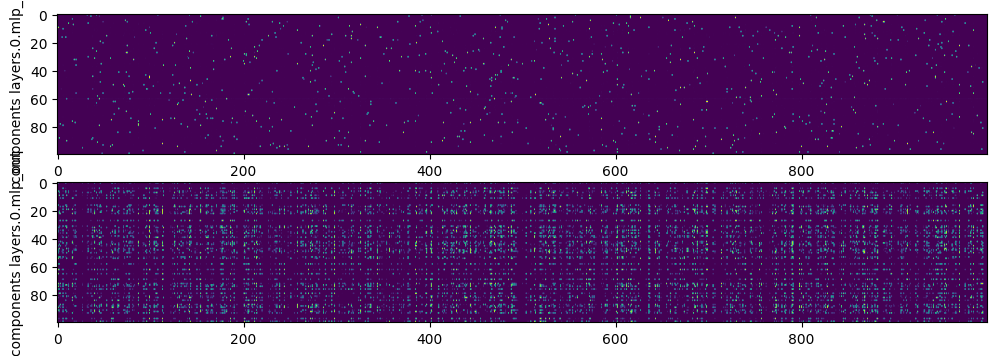

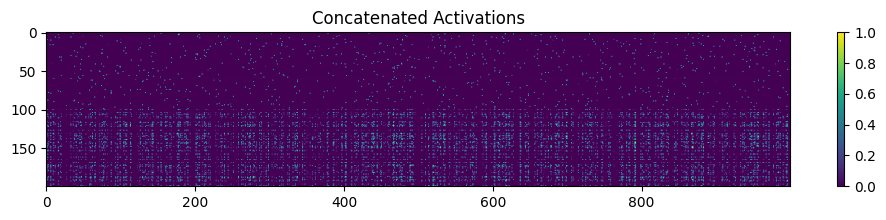

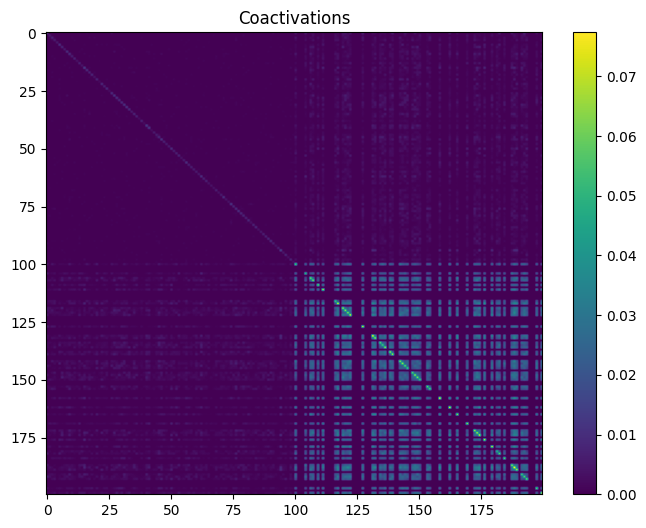

In [82]:
def process_activations(
	activations: dict[str, Float[Tensor, " n_steps C"]], # module name to sample x component gate activations
	plots: bool = False,
) -> dict[str, Any]:
	"""get back a dict of coactivations, slices, and concated activations"""
	
	# compute the slices
	total_c: int = 0
	slices: dict[str, slice] = dict()
	for key, act in activations.items():
		c = act.shape[-1]
		slices[key] = slice(total_c, total_c + c)
		total_c += c

	# concat the activations
	act_concat: Float[Tensor, " n_steps C"] = torch.cat(
		[activations[key] for key in activations.keys()], dim=-1
	)

	# compute coactivations
	coact: Float[Tensor, " C C"] = act_concat.T @ act_concat / act_concat.shape[0]

	# return the output
	output: dict[str, Any] = dict(
		activations=act_concat,
		slices=slices,
		coactivations=coact,
	)

	dbg_auto(output)

	if plots:
		# raw activations
		_, axs_act = plt.subplots(len(activations), 1, figsize=(12, 4))
		for i, (key, act) in enumerate(activations.items()):
			axs_act[i].imshow(act.T.cpu().numpy(), aspect="auto")
			axs_act[i].set_ylabel(f"components {key}")

		# concatenated activations
		plt.figure(figsize=(12, 2))
		plt.imshow(act_concat.T.cpu().numpy(), aspect="auto")
		plt.title("Concatenated Activations")
		plt.colorbar()

		# coactivations
		plt.figure(figsize=(8, 6))
		plt.imshow(coact.cpu().numpy(), aspect="auto")
		plt.title("Coactivations")
		plt.colorbar()

	return output



coa = process_activations(ci, plots=True);





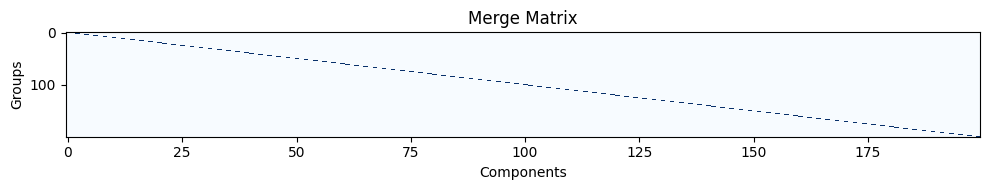

In [79]:
from spd.clustering.merge_matrix import GroupMerge

gm_ident = GroupMerge.identity(n_components=200)

gm_ident.plot(figsize=(10, 2))

$$
	F_g := \frac{\alpha}{n}
	\Bigg[
		d(A(g)) \cdot Q^T 
		+ Q \cdot d(A(g))^T
		- \Big(
			R \mathbf{1}^T
			+ \mathbf{1} R^T + \alpha^{-1}
		\Big) 
		\odot A(g)
	\Bigg]
$$

In [80]:
def compute_merge_costs(
    coact: Bool[Tensor, "k_groups k_groups"],
    merges: GroupMerge,
    alpha: float = 1.0,
    # rank_cost: Callable[[float], float] = lambda c: math.log(c),
    rank_cost: Callable[[float], float] = lambda _: 1.0,
) -> Float[Tensor, "k_groups k_groups"]:
    """Compute MDL costs for merge matrices"""
    device: torch.device = coact.device
    ranks: Float[Tensor, " k_groups"] = merges.components_per_group.to(device=device).float()
    diag: Float[Tensor, " k_groups"] = torch.diag(coact).to(device=device)

    # dbg_tensor(coact)
    # dbg_tensor(ranks)
    # dbg_tensor(diag)

    return alpha * (
        diag @ ranks.T
        + ranks @ diag.T
        - (
            ranks.unsqueeze(0) 
            + ranks.unsqueeze(1)
            + (rank_cost(merges.k_groups) / alpha)
        ) * coact
    )

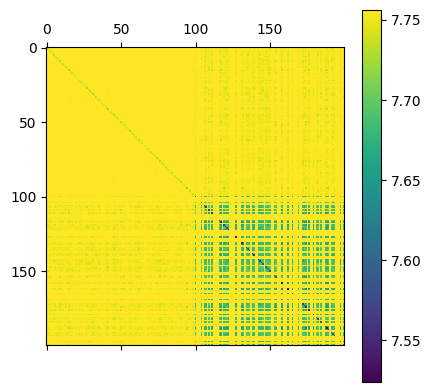

In [84]:
costs = compute_merge_costs(
	coact=coa['coactivations'],
	merges=gm_ident,
)
plt.matshow(costs.cpu(), cmap='viridis')
plt.colorbar()